In [14]:
from typing import Optional, List, Dict
import os
import time
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")

In [2]:
config = {
    'inputdir': '/eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI',
    # change your output directory here
    'outdir': os.path.join(os.environ['hh_combination_fw_path'], 'outputs_newCDI'),
    'scenarios': ['SM'] + [f'BM{i}' for i in range(1, 7 + 1)],
    'channels': ['bbyy', 'bbtautau'],
    'resonant_type': 'nonres',
    'file_expr': '<mass[F]>',
    'correlation_scheme': 'HEFT_nonres_v2.json',
    'task_option': 'HEFT_nonres_v1.yaml',
    'parallel': -1,
    'ranking': ['SM', 'BM3', 'BM5'],
    'ranking_exclude': 'gamma_*,nbkg_*,ATLAS_norm_*,BKG_*',
}

In [3]:
def construct_commands(config:Dict):
    channels = ','.join(config['channels'])
    hhcomb_path = os.environ.get('hh_combination_fw_path', None)
    if hhcomb_path is None:
        raise RuntimeError("hh combination framework is not set up properly, please run setup.sh first")
    task_option_path = os.path.join(hhcomb_path, "configs", "task_options", config['task_option'])
    correlation_scheme_path = os.path.join(hhcomb_path, "configs", "correlation_schemes", config['correlation_scheme'])
    if not os.path.exists(task_option_path):
        raise FileNotFoundError(f"file \"{task_option_path}\" does not exist")
    if not os.path.exists(correlation_scheme_path):
        raise FileNotFoundError(f"file \"{correlation_scheme_path}\" does not exist")
    file_expr = config['file_expr']
    commands = {'process_channels': [], 'combine_ws': []}
    for scenario in config['scenarios']:
        input_path = os.path.join(config['inputdir'], scenario)
        output_path = os.path.join(config['outdir'], scenario)
        # process channels
        command_channel = f"HHComb process_channels -i {input_path} -c \"{channels}\" -r {config['resonant_type']} " +\
                          f"-o {output_path} --file_expr \"{file_expr}\" --config {task_option_path} " +\
                          f"--parallel {config['parallel']} --unblind"
        commands['process_channels'].append(command_channel)
        # combination
        command_comb = f"HHComb combine_ws -i {output_path} -s {correlation_scheme_path} -c \"{channels}\" " +\
                       f"-r {config['resonant_type']} --file_expr \"{file_expr}\" --config {task_option_path} " +\
                       f"--parallel {config['parallel']} --unblind"
        commands['combine_ws'].append(command_comb)
    for command_type in commands:
        # parallelization
        commands[command_type] = ' & '.join(commands[command_type])
    return commands

In [8]:
commands = construct_commands(config)

In [9]:
print("# commands for processing individual channels")
print()
print(commands['process_channels'])
print()
print("# commands for combination")
print()
print(commands['combine_ws'])

# commands for processing individual channels

HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI/SM -c "bbyy,bbtautau" -r nonres -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM --file_expr "<mass[F]>" --config /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/configs/task_options/HEFT_nonres_v1.yaml --parallel -1 --unblind & HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/diHiggs/combination/FullRun2Workspaces/original/PUBHEFT2022/20220301_HEFT_newCDI/BM1 -c "bbyy,bbtautau" -r nonres -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM1 --file_expr "<mass[F]>" --config /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/configs/task_options/HEFT_nonres_v1.yaml --parallel -1 --unblind & HHComb process_channels -i /eos/atlas/atlascerngroupdisk/phys-hdbs/di

In [26]:
!{commands['process_channels']}

^C


In [14]:
!{commands['combine_ws']}




RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                All rights reserved, please read http://roofit.sourceforge.net/license.txt
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                All rights reserved, please read http://roofit.sourceforge.net/license.txt
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University

                All rights reserved, please read http://roofit.sourceforge.net/license.t

INFO: Task finished. Total time taken: 1.042 s


## Plot limit results

In [4]:
from quickstats.plots import UpperLimitBenchmarkPlot
from quickstats.utils.common_utils import combine_dict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
limit_data = {}
for channel in config['channels'] + ['combined']:
    limit_data[channel] = {}
    for scenario in config['scenarios']:
        outdir = os.path.join(config['outdir'], scenario, 'limits', config['resonant_type'], channel)
        if channel != 'combined':
            limit_path = os.path.join(outdir, "limits.json")
        else:
            limit_path = os.path.join(outdir, "A-{}-fullcorr".format("_".join(sorted(config['channels']))), "limits.json")
        if not os.path.exists(limit_path):
            raise FileNotFoundError(f"file \"{limit_path}\" not found")
        limit_data[channel][scenario] = {k:v[0] for k,v in json.load(open(limit_path)).items()}
    limit_data[channel] = pd.DataFrame(limit_data[channel]).transpose()

In [6]:
limit_data['bbyy'] # uncorrelated

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.171602,0.380443,0.253667,0.123648,0.092103,0.127717,0.0
BM1,0.0,0.293047,0.632478,0.429199,0.211157,0.157286,0.189293,0.0
BM2,0.0,0.267654,0.584390,0.393500,0.192860,0.143657,0.183191,0.0
BM3,0.0,0.163151,0.366355,0.242232,0.117559,0.087567,0.109803,0.0
BM4,0.0,0.155759,0.347234,0.230660,0.112233,0.083600,0.111213,0.0
BM5,0.0,0.137676,0.308283,0.204171,0.099203,0.073894,0.097811,0.0
BM6,0.0,0.188888,0.418502,0.279198,0.136105,0.101381,0.134377,0.0
BM7,0.0,0.126305,0.283067,0.187358,0.091009,0.067791,0.088933,0.0


In [32]:
uncorrelated = limit_data['combined'] # uncorrelated

In [35]:
correlated = limit_data['combined'] # correlated

In [37]:
correlated

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089084,0.178788,0.126917,0.064190,0.047814,0.088130,0.0
BM1,0.0,0.130150,0.264599,0.186286,0.093781,0.069855,0.135019,0.0
BM2,0.0,0.135001,0.273112,0.192854,0.097276,0.072459,0.134939,0.0
BM3,0.0,0.056925,0.120798,0.082679,0.041017,0.030553,0.062868,0.0
BM4,0.0,0.065553,0.132005,0.093531,0.047235,0.035184,0.069159,0.0
BM5,0.0,0.054338,0.112145,0.078157,0.039154,0.029165,0.058420,0.0
BM6,0.0,0.086484,0.174127,0.123363,0.062316,0.046418,0.089150,0.0
BM7,0.0,0.046001,0.093215,0.065780,0.033146,0.024690,0.050392,0.0


In [38]:
uncorrelated

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089084,0.178788,0.126917,0.064190,0.047814,0.088130,0.0
BM1,0.0,0.130082,0.264147,0.186117,0.093731,0.069818,0.134933,0.0
BM2,0.0,0.134864,0.272277,0.192528,0.097177,0.072385,0.134818,0.0
BM3,0.0,0.056759,0.119747,0.082282,0.040898,0.030464,0.062568,0.0
BM4,0.0,0.065543,0.131943,0.093506,0.047227,0.035178,0.069143,0.0
BM5,0.0,0.054226,0.111482,0.077897,0.039073,0.029105,0.058250,0.0
BM6,0.0,0.086439,0.173869,0.123260,0.062284,0.046394,0.089089,0.0
BM7,0.0,0.045996,0.093185,0.065768,0.033143,0.024687,0.050382,0.0


In [40]:
(uncorrelated / correlated - 1)*100

,mass,0,2,1,-1,-2,obs,inj
SM,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
BM1,NaN,-0.052642,-0.170877,-0.090632,-0.052642,-0.052642,-0.063998,NaN
BM2,NaN,-0.101823,-0.305812,-0.169451,-0.101823,-0.101823,-0.089242,NaN
BM3,NaN,-0.290672,-0.869602,-0.480645,-0.290672,-0.290672,-0.476864,NaN
BM4,NaN,-0.016327,-0.046707,-0.026628,-0.016327,-0.016327,-0.023686,NaN
BM5,NaN,-0.205786,-0.590919,-0.332174,-0.205786,-0.205786,-0.290065,NaN
BM6,NaN,-0.051283,-0.148645,-0.084013,-0.051283,-0.051283,-0.068356,NaN
BM7,NaN,-0.011115,-0.032189,-0.018054,-0.011115,-0.011115,-0.019698,NaN


In [9]:
limit_data['bbyy']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.171602,0.380443,0.253667,0.123648,0.092103,0.127717,0.0
BM1,0.0,0.293002,0.632167,0.429087,0.211124,0.157262,0.189266,0.0
BM2,0.0,0.267250,0.582051,0.392565,0.192569,0.143440,0.183012,0.0
BM3,0.0,0.163105,0.366054,0.242120,0.117526,0.087543,0.109777,0.0
BM4,0.0,0.155741,0.347118,0.230617,0.112220,0.083590,0.111202,0.0
BM5,0.0,0.137836,0.309310,0.204554,0.099319,0.073980,0.097897,0.0
BM6,0.0,0.189030,0.419398,0.279539,0.136207,0.101457,0.134455,0.0
BM7,0.0,0.126212,0.282474,0.187137,0.090943,0.067741,0.088889,0.0


In [19]:
limit_data['bbyy']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.171222,0.379666,0.253113,0.123375,0.091899,0.127700,0.0
BM1,0.0,0.292315,0.630756,0.428086,0.210629,0.156893,0.189235,0.0
BM2,0.0,0.266603,0.580714,0.391620,0.192102,0.143093,0.182984,0.0
BM3,0.0,0.162748,0.365314,0.241597,0.117269,0.087351,0.109734,0.0
BM4,0.0,0.155404,0.346426,0.230125,0.111977,0.083409,0.111165,0.0
BM5,0.0,0.137546,0.308715,0.204130,0.099110,0.073825,0.097861,0.0
BM6,0.0,0.188601,0.418513,0.278912,0.135898,0.101227,0.134407,0.0
BM7,0.0,0.125951,0.281944,0.186756,0.090755,0.067601,0.088850,0.0


In [10]:
limit_data['bbtautau']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.110072,0.221439,0.156950,0.079313,0.059078,0.130917,0.0
BM1,0.0,0.150492,0.311993,0.216873,0.108438,0.080773,0.195845,0.0
BM2,0.0,0.163731,0.335533,0.234983,0.117977,0.087879,0.203092,0.0
BM3,0.0,0.062918,0.136279,0.092149,0.045336,0.033770,0.082831,0.0
BM4,0.0,0.075445,0.153036,0.107949,0.054363,0.040494,0.094591,0.0
BM5,0.0,0.061615,0.129075,0.089061,0.044397,0.033070,0.078499,0.0
BM6,0.0,0.101845,0.206396,0.145642,0.073385,0.054663,0.126086,0.0
BM7,0.0,0.051236,0.104829,0.073535,0.036919,0.027500,0.065890,0.0


In [20]:
limit_data['bbtautau']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.110072,0.221439,0.156950,0.079313,0.059078,0.130917,0.0
BM1,0.0,0.150492,0.311993,0.216873,0.108438,0.080773,0.195845,0.0
BM2,0.0,0.163731,0.335533,0.234983,0.117977,0.087879,0.203092,0.0
BM3,0.0,0.062918,0.136279,0.092149,0.045336,0.033770,0.082831,0.0
BM4,0.0,0.075445,0.153036,0.107949,0.054363,0.040494,0.094591,0.0
BM5,0.0,0.061615,0.129075,0.089061,0.044397,0.033070,0.078499,0.0
BM6,0.0,0.101845,0.206396,0.145642,0.073385,0.054663,0.126086,0.0
BM7,0.0,0.051236,0.104829,0.073535,0.036919,0.027500,0.065890,0.0


In [11]:
limit_data['combined']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089084,0.178788,0.126917,0.064190,0.047814,0.088130,0.0
BM1,0.0,0.130150,0.264599,0.186286,0.093781,0.069855,0.135019,0.0
BM2,0.0,0.135001,0.273112,0.192854,0.097276,0.072459,0.134939,0.0
BM3,0.0,0.056925,0.120798,0.082679,0.041017,0.030553,0.062868,0.0
BM4,0.0,0.065553,0.132005,0.093531,0.047235,0.035184,0.069159,0.0
BM5,0.0,0.054338,0.112145,0.078157,0.039154,0.029165,0.058420,0.0
BM6,0.0,0.086484,0.174127,0.123363,0.062316,0.046418,0.089150,0.0
BM7,0.0,0.046001,0.093215,0.065780,0.033146,0.024690,0.050392,0.0


In [21]:
limit_data['combined']

,mass,0,2,1,-1,-2,obs,inj
SM,0.0,0.089020,0.178672,0.126831,0.064144,0.047779,0.088125,0.0
BM1,0.0,0.130076,0.264446,0.186179,0.093727,0.069815,0.135023,0.0
BM2,0.0,0.134902,0.272922,0.192716,0.097205,0.072406,0.134935,0.0
BM3,0.0,0.056902,0.120748,0.082647,0.041001,0.030541,0.062865,0.0
BM4,0.0,0.065520,0.131943,0.093485,0.047211,0.035167,0.069157,0.0
BM5,0.0,0.054314,0.112095,0.078122,0.039136,0.029151,0.058416,0.0
BM6,0.0,0.086432,0.174031,0.123291,0.062279,0.046390,0.089146,0.0
BM7,0.0,0.045983,0.093180,0.065754,0.033133,0.024680,0.050389,0.0


In [7]:
for channel in limit_data:
    output_path = os.path.join(config['outdir'], f"BM_limits_{channel}.json")
    json.dump(limit_data[channel].to_dict('index'), open(output_path, "w"), indent=2)

In [18]:
label_map = {
    'SM': 'SM',
    'BM1': '1',
    'BM2': '2',
    'BM3': '3',
    'BM4': '4',
    'BM5': '5',
    'BM6': '6',
    'BM7': '7'
}
analysis_label_options = {
    'energy': '13 TeV',
    'lumi': '139 fb$^{-1}$',
    'fontsize': 30,
    'status': 'prelim'
}
channel_text = {
    'bbtautau': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
    'bbyy': r'$\mathrm{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'combined': r'$\mathrm{HH\rightarrow b\bar{b}\tau^+\tau^-} + b\bar{b}\gamma\gamma$'
}
styles = {
    'legend':{
        'loc': (0.5, 0.68)
    }
}
plot_config = {
    'markersize': 60
}
ylim = {
    'bbyy': (18, 6000),
    'bbtautau': (18, 3000),
    'combined': (18, 2000),
}

In [19]:
from pdb import set_trace
def plot_benchmark_limit(all_data, channel:str, save_as:Optional[str]=None):
    data = all_data[channel]
    label_options = {**analysis_label_options, 'extra_text': channel_text[channel]}
    plotter = UpperLimitBenchmarkPlot(data, label_map, limit_scale=1000,
                                  styles=styles, config=plot_config,
                                  analysis_label_options=label_options)
#     plotter.add_hline(y=31.05, color='#F2385A', label=r'$\sigma^{\mathrm{SM}}_{\mathrm{ggF\, HH}}$')
    plotter.draw(ylabel="$\sigma_{\mathrm{ggF}}$ (HH) [fb]", xlabel="Benchmark model",
                 logy=True, ylim=ylim[channel])
    if save_as is not None:
        plt.savefig(save_as, bbox_inches="tight")
        data.to_csv(save_as.replace('pdf', 'csv'))
        with open(save_as.replace('pdf', 'json'), 'w') as fp:
            json.dump(data.to_dict("index"), fp, indent=2)

In [20]:
plot_outdir = os.path.join(config['outdir'], 'plots')
if not os.path.exists(plot_outdir):
    os.makedirs(plot_outdir)

<Figure size 432x288 with 0 Axes>

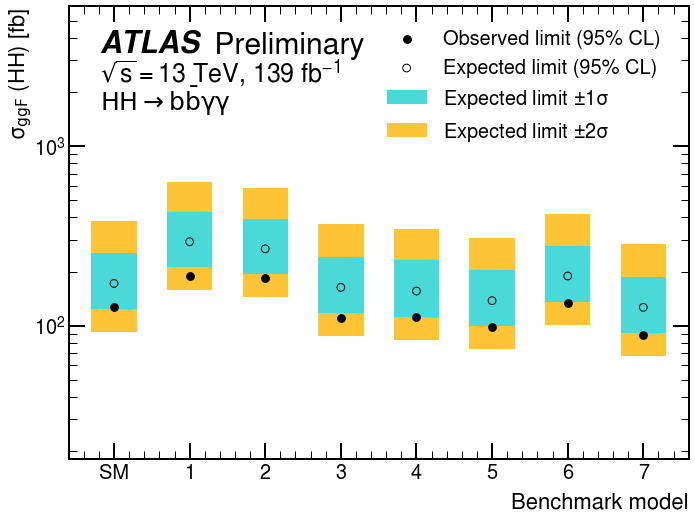

<Figure size 432x288 with 0 Axes>

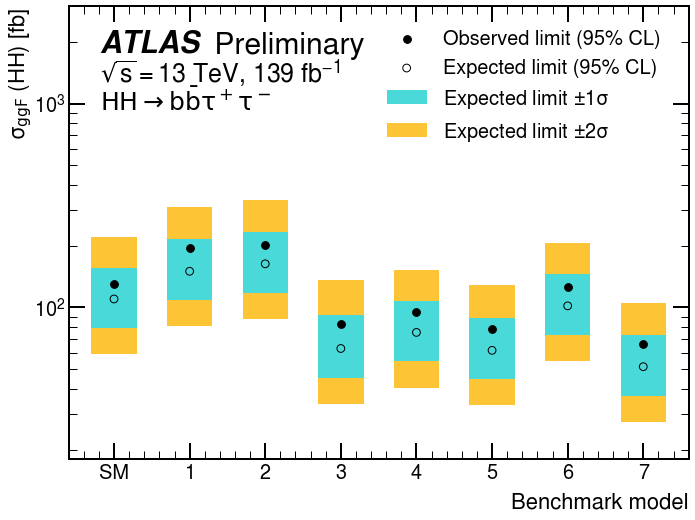

<Figure size 432x288 with 0 Axes>

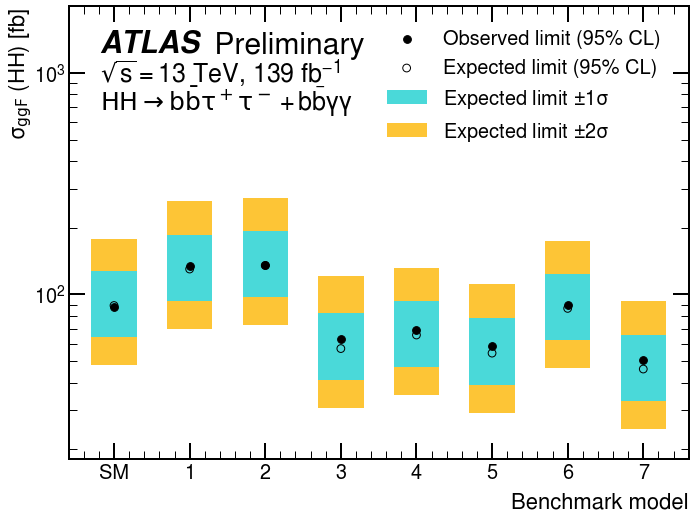

In [21]:
for channel in limit_data:
    save_path = os.path.join(plot_outdir, f'{channel}_benchmark_limit.pdf')
    plot_benchmark_limit(limit_data, channel, save_as=save_path)
    plt.show()

## Ranking

In [5]:
def construct_ranking(config:Dict):
    inputs = ['combined/nonres/A-bbtautau_bbyy-fullcorr/0', 'rescaled/nonres/bbyy/0', 'rescaled/nonres/bbtautau/0']
    outputs = ['combined', 'bbyy', 'bbtautau']
    hhcomb_path = os.environ.get('hh_combination_fw_path', None)
    if hhcomb_path is None:
        raise RuntimeError("hh combination framework is not set up properly, please run setup.sh first")
    task_option_path = os.path.join(hhcomb_path, "configs", "task_options", config['task_option'])
    correlation_scheme_path = os.path.join(hhcomb_path, "configs", "correlation_schemes", config['correlation_scheme'])
    if not os.path.exists(task_option_path):
        raise FileNotFoundError(f"file \"{task_option_path}\" does not exist")
    if not os.path.exists(correlation_scheme_path):
        raise FileNotFoundError(f"file \"{correlation_scheme_path}\" does not exist")
    file_expr = config['file_expr']
    commands = {'ranking': [], 'plotting': [], 'genasimov': []}
    for scenario in config['ranking']:
        output_path = os.path.join(config['outdir'], scenario)
        # process channels
        for ws, out in zip(inputs, outputs):
            command_channel = f"quickstats generate_standard_asimov -t -2 --poi xsec_br -i {output_path}/{ws}.root " +\
                              f"-o {output_path}/{ws}_ranking.root &"
            commands['genasimov'].append(command_channel)
            
            
            command_channel = f"quickstats run_pulls --batch_mode --poi xsec_br " +\
                            f" --parallel {config['parallel']} --exclude {config['ranking_exclude']} " +\
                            f" -i {output_path}/{ws}_ranking.root -o {output_path}/ranking/{out} -d asimovData_1_NP_Nominal"
            commands['ranking'].append(command_channel)
            
            
            command_channel = f"quickstats plot_pulls --poi xsec_br -i {output_path}/ranking/{out} " +\
                              f"--outdir {output_path}/figures/{out} -o {out} &"
            commands['plotting'].append(command_channel)

    return commands

In [6]:
commands = construct_ranking(config)

#### Generate S+B Asimov

In [7]:
print("# commands for ranking channels")
print()
for command in commands['genasimov']:
    print(command+'\n')

# commands for ranking channels

quickstats generate_standard_asimov -t -2 --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/combined/nonres/A-bbtautau_bbyy-fullcorr/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/combined/nonres/A-bbtautau_bbyy-fullcorr/0_ranking.root &

quickstats generate_standard_asimov -t -2 --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/nonres/bbyy/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/nonres/bbyy/0_ranking.root &

quickstats generate_standard_asimov -t -2 --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/nonres/bbtautau/0.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/nonres/bbtautau/0_ranking.root &

quic

#### fitting

In [8]:
print("# commands for ranking channels")
print()
for command in commands['ranking']:
    print(command+'\n')

# commands for ranking channels

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/combined/nonres/A-bbtautau_bbyy-fullcorr/0_ranking.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/ranking/combined -d asimovData_1_NP_Nominal

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/nonres/bbyy/0_ranking.root -o /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/ranking/bbyy -d asimovData_1_NP_Nominal

quickstats run_pulls --batch_mode --poi xsec_br  --parallel -1 --exclude gamma_*,nbkg_*,ATLAS_norm_*,BKG_*  -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/rescaled/n

#### plotting

In [9]:
print("# commands for plotting ranking")
print()
for command in commands['plotting']:
    print(command+'\n')

# commands for plotting ranking

quickstats plot_pulls --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/ranking/combined --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/figures/combined -o combined &

quickstats plot_pulls --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/ranking/bbyy --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/figures/bbyy -o bbyy &

quickstats plot_pulls --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/ranking/bbtautau --outdir /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/SM/figures/bbtautau -o bbtautau &

quickstats plot_pulls --poi xsec_br -i /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/outputs_newCDI/BM3/ranking/combined --outdir /afs/c